In [1]:
import pandas as pd
import SnowDepth.data_loader as DL
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Inspect data. Also includes an inspection of FF algos at the end

In [2]:
# Path to TIFF files
data_dir = "data/tif_files"

# Load dataframe (valid pixels only)
df = DL.build_df(str(data_dir), drop_invalid=True, upper_threshold=3)

# Count pixels per AOI
counts = df["aoi_name"].value_counts().reset_index()
counts.columns = ["AOI", "Pixel_count"]
valid_pixels = counts["Pixel_count"].sum()

print("\nPixel count per AOI:")
print(counts.to_string(index=False))
print(f"\nTotal valid pixels (SD ≤ 3 m): {valid_pixels:,}")

# Build other DataFrames for comparison
df_with_invalid = DL.build_df(str(data_dir), drop_invalid=False, upper_threshold=3)
df_without_threshold = DL.build_df(str(data_dir), drop_invalid=True, upper_threshold=None)

total_pixels = len(df_with_invalid)
no_threshold_pixels = len(df_without_threshold)

# Calculate pixel counts
invalid_pixels = total_pixels - len(df_without_threshold)
above_threshold = no_threshold_pixels - valid_pixels

print(f"\nTotal pixels (including invalid): {total_pixels:,}")
print(f"Pixels dropped (invalid or negative SD): {invalid_pixels:,}")
print(f"Pixels with SD > 3 m removed: {above_threshold:,}")



Pixel count per AOI:
  AOI  Pixel_count
ID_BS      1655714
CO_FR       619073
ID_DC       375912
ID_MC       344285
UT_LC       260920
CO_CP       206802

Total valid pixels (SD ≤ 3 m): 3,462,706

Total pixels (including invalid): 5,945,438
Pixels dropped (invalid or negative SD): 2,451,614
Pixels with SD > 3 m removed: 31,118


In [3]:
# Check descriptive statistics, click view as scrollable element to see all
pd.set_option('display.float_format', '{:.2f}'.format)
numeric_feats = [c for c in df.columns if c not in ('aoi_name','row','col')]

print("\nDescriptive Statistics:")
print(df[numeric_feats].describe().drop(index='count'))


Descriptive Statistics:
      Sigma_VH  Sigma_VV  Gamma_VH  Gamma_VV  Beta_VH  Beta_VV  Gamma_VH_RTC  \
mean    -17.31    -10.66    -16.12     -9.47   -15.43    -8.78        -17.04   
std       3.66      4.62      3.64      4.59     3.70     4.67          2.77   
min     -48.96    -38.03    -50.05    -36.27   -49.55   -35.78       -120.00   
25%     -19.58    -13.53    -18.37    -12.31   -17.73   -11.68        -18.04   
50%     -17.27    -11.32    -16.06    -10.10   -15.42    -9.47        -16.73   
75%     -15.04     -8.42    -13.85     -7.23   -13.15    -6.53        -15.65   
max      12.03     20.68     12.85     21.49    14.54    23.21         11.51   

      Gamma_VV_RTC  Sigma_sum  Gamma_sum  ...  Beta_ratio  Gamma_RTC_ratio  \
mean        -10.41       0.26       0.33  ...       -6.65            -6.63   
std           2.98       1.34       1.62  ...        2.28             2.21   
min        -120.00       0.00       0.00  ...      -34.13           -37.63   
25%         -11.59    

As we can see, there some SD values that are negative, and the max SD indicates some outliers

In [4]:
# Check for missing values, click view as scrollable element to see all
print("\nMissing Values per Column:")
print(df[numeric_feats].isna().sum())


Missing Values per Column:
Sigma_VH           0
Sigma_VV           0
Gamma_VH           0
Gamma_VV           0
Beta_VH            0
Beta_VV            0
Gamma_VH_RTC       0
Gamma_VV_RTC       0
Sigma_sum          0
Gamma_sum          0
Beta_sum           0
Gamma_RTC_sum      0
Sigma_diff         0
Gamma_diff         0
Beta_diff          0
Gamma_RTC_diff     0
Sigma_ratio        0
Gamma_ratio        0
Beta_ratio         0
Gamma_RTC_ratio    0
LIA                0
IAFE               0
Elevation          0
Slope              0
sin_Aspect         0
cos_Aspect         0
Veg_height         0
SD                 0
dtype: int64


In [5]:
# Check that filtering nan, negative and SD > 3m works (This is false SD values)
nan_rows = df['SD'].isna().sum()
print(f"NaN SD values: {nan_rows}")

negative_rows = len(df[(df['SD'] < 0)])
print(f"Negative SD values: {negative_rows}")

outlier_rows = len(df[(df['SD'] > 3)])
print(f"SD values above 3 m: {outlier_rows}")

NaN SD values: 0
Negative SD values: 0
SD values above 3 m: 0


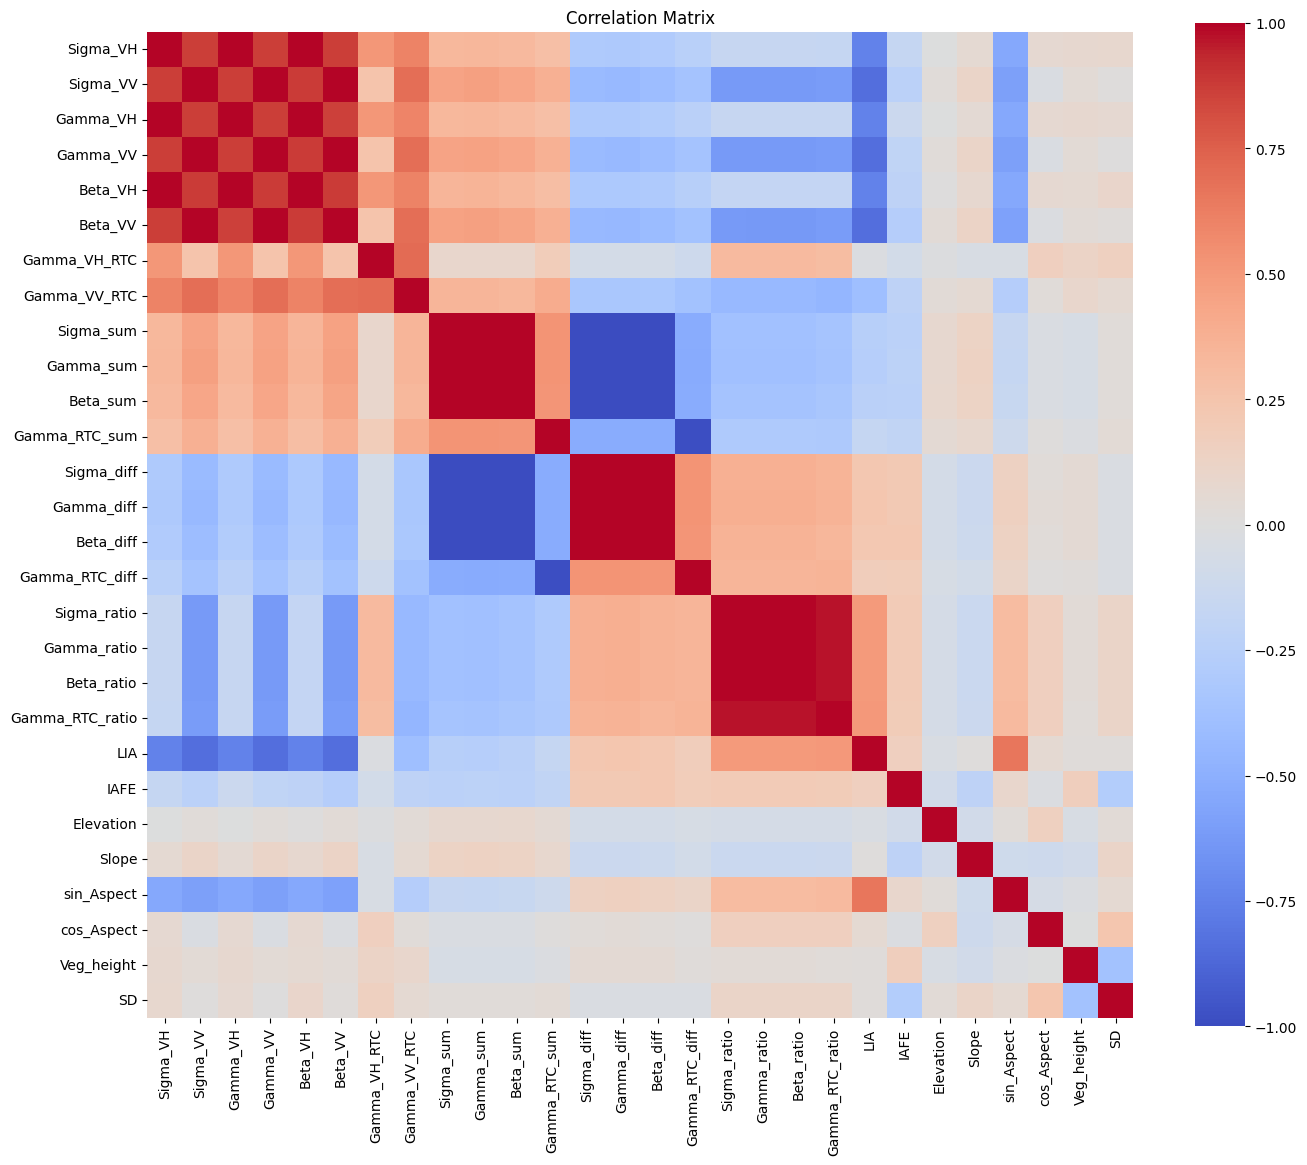

In [6]:
# Plot Correlation Matrix
variables = [c for c in df.select_dtypes(include=[np.number]).columns
             if c not in ('row','col')]

X = df[variables].replace([np.inf, -np.inf], np.nan)
corr = X.corr()

plt.figure(figsize=(max(8, 0.5*len(variables)), max(6, 0.5*len(variables))))
sns.heatmap(corr, annot=len(variables)<=15, fmt='.2f',
            cmap='coolwarm', vmin=-1, vmax=1, square=True,
            cbar_kws={'shrink': .75})
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()



In [7]:
# Inspection of FF algorithms output
from pathlib import Path
import sys, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SnowDepth.optimal_features as FF
from SnowDepth.optimal_features import sample_per_aoi
from SnowDepth.config import HOLDOUT_AOI, SEED

# Use development set only
dev_df = df[df["aoi_name"] != HOLDOUT_AOI].copy()

# Which columns are eligible as features
feature_cols = [c for c in dev_df.columns if c not in ("aoi_name","row","col","SD")]

TOP_K = 10


Block HSIC Lasso B = 20.
M set to 3.
Using Gaussian kernel for the features, Gaussian kernel for the outcomes.
['27', '22', '26', '7', '8', '17', '5', '20', '24', '21']
[26, 21, 25, 6, 7, 16, 4, 19, 23, 20]
[0.10204563 0.09198634 0.0192371  0.01460614 0.01455011 0.00929264
 0.00672781 0.00536722 0.00322299 0.00261073]


In [8]:
# Use 10000 samples to not blow up runtime
samples = sample_per_aoi(dev_df, n_per_aoi=20000)

# HSIC
hsic_selected, hsic_top = FF.hsic_lasso_select(samples, feature_cols, top_k=TOP_K)
# hsic_top has only top_k (feature, score)

# PCC
pcc_selected, pcc_rank, pcc_inter = FF.pcc_select(
    samples, feature_cols, top_k=TOP_K, max_intercorr=0.90, min_abs_corr=0.0
)

# pcc_rank has full ranking with columns ['feature','pcc','abs_pcc']
# pcc_inter is inter-correlation among the top_k candidates

# MI
mi_selected, mi_rank, mi_inter = FF.mi_select(
    samples, feature_cols, top_k=TOP_K, max_intercorr=0.90, n_neighbors=5
)

# mi_rank has full ranking with ['feature','mi']
# mi_inter is inter-correlation among the top_k candidates

print("HSIC:", hsic_selected)
print("PCC :", pcc_selected)
print("MI  :", mi_selected)


Block HSIC Lasso B = 20.
M set to 3.
Using Gaussian kernel for the features, Gaussian kernel for the outcomes.
HSIC: ['Veg_height', 'IAFE', 'cos_Aspect', 'Gamma_VH_RTC', 'Gamma_VV_RTC', 'Sigma_ratio', 'Beta_VH', 'Gamma_RTC_ratio', 'Slope', 'LIA']
PCC : ['Veg_height', 'IAFE', 'cos_Aspect', 'Gamma_VH_RTC', 'sin_Aspect', 'Gamma_RTC_ratio', 'Beta_VH']
MI  : ['IAFE', 'Elevation', 'Veg_height', 'cos_Aspect', 'Gamma_RTC_sum', 'Gamma_VH_RTC', 'Gamma_VV_RTC', 'Slope', 'Beta_VH']


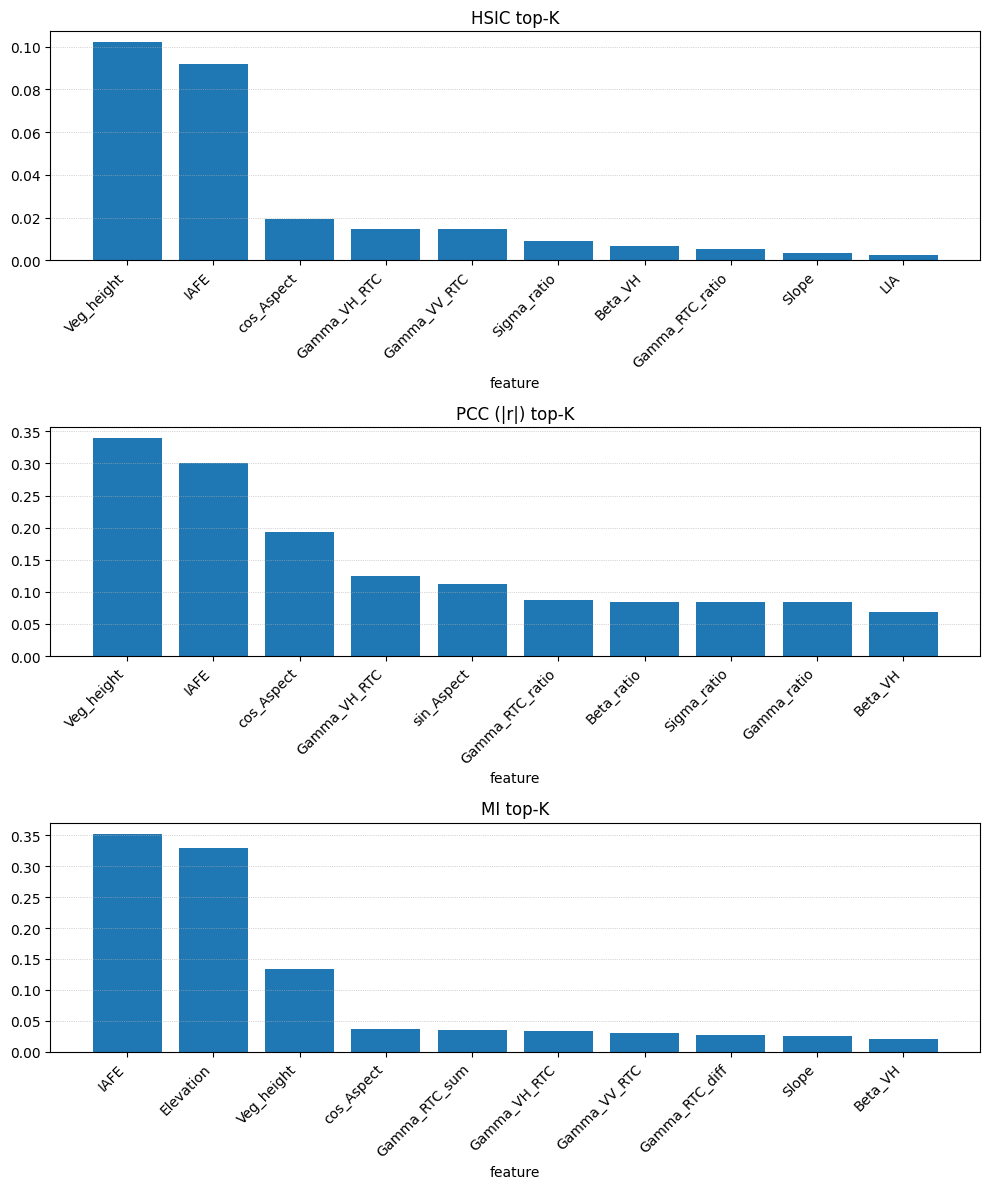

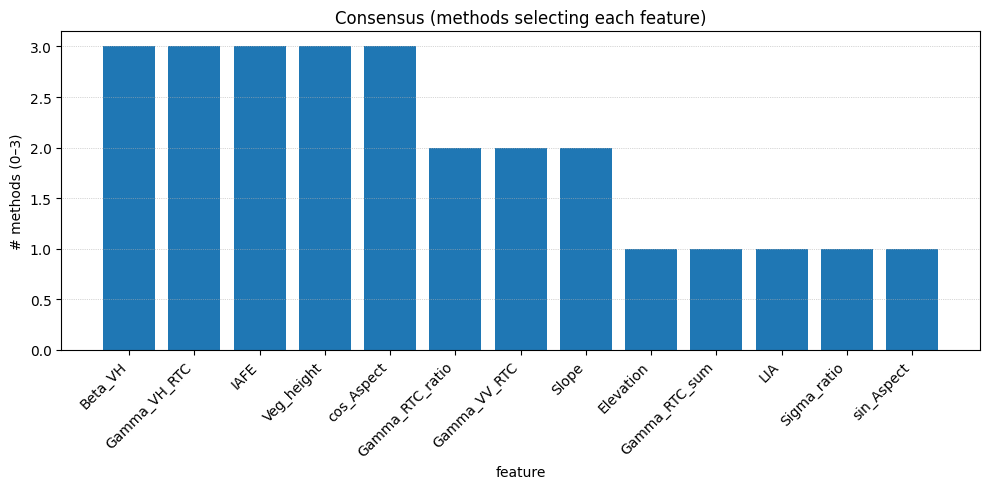

In [10]:
# Prep top-k tables (ensure consistent columns)
hsic_tbl = hsic_top.copy()  # columns: ['feature','score']
hsic_tbl = hsic_tbl.head(TOP_K).reset_index(drop=True)

pcc_tbl  = pcc_rank.loc[:, ['feature','abs_pcc']].head(TOP_K).reset_index(drop=True)
mi_tbl   = mi_rank.loc[:, ['feature','mi']].head(TOP_K).reset_index(drop=True)

def bar(ax, names, values, title, xlabel):
    ax.bar(range(len(values)), values)
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(names, rotation=45, ha="right")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.grid(True, axis='y', linestyle=':', linewidth=0.5)

# Top-K bars for each method
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
bar(axes[0], hsic_tbl['feature'], hsic_tbl['score'], "HSIC top-K", "feature")
bar(axes[1], pcc_tbl['feature'],  pcc_tbl['abs_pcc'], "PCC (|r|) top-K", "feature")
bar(axes[2], mi_tbl['feature'],   mi_tbl['mi'],       "MI top-K", "feature")
plt.tight_layout()
plt.show()


# Consensus across methods (how many picked each)
cons_counts = {}
for f in hsic_selected: cons_counts[f] = cons_counts.get(f, 0) + 1
for f in pcc_selected:  cons_counts[f] = cons_counts.get(f, 0) + 1
for f in mi_selected:   cons_counts[f] = cons_counts.get(f, 0) + 1
cons_df = (pd.DataFrame({"feature": list(cons_counts.keys()),
                         "n_methods": list(cons_counts.values())})
           .sort_values(["n_methods","feature"], ascending=[False, True]))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
bar(ax, cons_df['feature'], cons_df['n_methods'], "Consensus (methods selecting each feature)", "feature")
ax.set_ylabel("# methods (0–3)")
plt.tight_layout(); plt.show()
